<a href="https://colab.research.google.com/github/thomasarmstrong98/thirdyearproj/blob/master/two_param_logitic_grid_approx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
import scipy.stats
import statsmodels.stats.api as sms
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from IPython.display import HTML
import math

from google.colab import files

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [0]:
!pip install --upgrade numpy
print (np.__version__)

    100% |████████████████████████████████| 17.3MB 1.6MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


1.14.6


## ODE Model
Suppose we are given some experimental for a system which we believe follows a Logisitic/Verhust-Pearl differential equation. We do not know the growth rate $r$ or the carrying capacity of the system $K$. We wish to estimate these parameters whilst still incorporating our piror knowledge about what values $r$ and $K$ may take.

The ODE model for the system we are considering is:

$$ \frac{dN}{dt} = r \: N(1-\frac{N}{K}) $$

This equation has a closed solution which can be written as :
$$ N(t) = \frac{Ce^{r t}}{1 + \frac{C}{K}e^{r t}}, \quad C=\frac{KN(0)}{K-N(0)}$$.
In this setting we will behave as if the initial condition $N(0)$ is known and is therefore not a parameter to consider. This allows us to compute the unique solution to this ODE at any time $t$ given parameters $r$ and $K$.

## Priors and Likelihood

#### Prior

We wish to specify pior distributions for the parameters $r$ and $K$. Here, they are a priori independent, where our prior for $r$ follows an Inverse-Gamma whilst $K$ follows a normal distribution.


$$ r \sim \text{Inv-Gamma}(\mu_0, \sigma_0^2) \quad \text{and} \quad K \sim \text{Norm} ( \mu_1, \sigma_1^2) $$

#### Likelihood


We will generate some random experimental data of m observations, $\mathbf{y} = (y_1, y_2, \ldots, y_m)$ below. We assume that this data takes the value of the solution of our ODE but has been disrupted by independent zero-mean Gaussian noise with a known varance $\tau^2$. That is,

$$ y_i = N(t_i) + \epsilon_i, \quad \text{where }  \epsilon_i, ..., \epsilon_m \sim  \text{Norm} ( 0 , \tau^2) $$

Which also implies:

$$ y_i \sim \text{Norm}(N(t_i), \tau^2) $$

Therefore, conditional on the parameters $r$ and $K$ we have the likelihood function:

$$ y_i \mid r, K \sim \text{Norm}(N(t_i; r, K), \tau^2) $$
where $N(t_i; r, K)$ denotes the solution of our ODE as described in the previous section but with parameters $r$ and $K$.


In [0]:
np.random.seed(2018)

r = 1.2
K = 4.6
initial_N = 0.1

def initial_cond(initial_N, K):
    return (K*initial_N) / (K - initial_N) 

def diff_eqn_soln(r, K, initial_N, t):
    C = initial_cond(initial_N, K)
    return C*np.exp(r*t)/(1 + (C/K)*np.exp(r*t))

In [0]:
t = np.linspace(0,20, 51)
sol_df = pd.DataFrame(index = t)
sol_df['N'] = diff_eqn_soln(r, K, initial_N, t)

In [0]:
#Corrupting our solution with Gaussian Noise
sd = 0.3

sim_df = pd.DataFrame(index = t)
experiment = [sol + scipy.stats.norm.rvs(0, sd) for sol in sol_df['N']]
sim_df['N'] = experiment

In [0]:
sim_df.head()

,N
0.0,0.016970
0.4,0.334027
0.8,0.896849
1.2,0.010606
1.6,0.756160


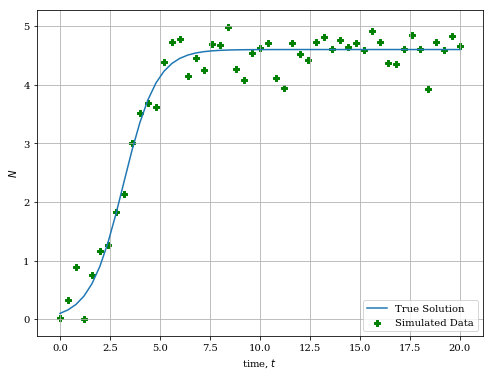

In [0]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8
fig_size[1] = 6

plt.plot(sol_df['N'])
plt.scatter(t, sim_df['N'], color = 'g', marker = 'P')
plt.grid(True)
plt.xlabel("time, $t$")
plt.ylabel("$N$")
plt.legend(["True Solution", "Simulated Data"], loc = 'lower right')
plt.show()

In [0]:
#Defining Prior, Log-Likelihood and the Posterior

def prior(r,K):
    return scipy.stats.norm.pdf(K, 5, 2)*scipy.stats.invgamma.pdf(r,a =1, loc = 0, scale = 2)

sd = 0.3

def log_likelihood(r, K, sim_df, t, initial_N):
    lik_sum = 0
    proposed_df = pd.DataFrame(index = t)
    proposed_df['N'] = diff_eqn_soln(r, K, initial_N, t)
    for index, obs in proposed_df.iterrows():
        lik_sum = lik_sum + np.log(scipy.stats.norm.pdf(proposed_df.loc[index], sim_df.loc[index], sd))
    return lik_sum
def posterior (r, K, sim_df, t, intial_N):
    return prior(r, K)*np.exp(log_likelihood(r, K, sim_df, t, initial_N))

In [0]:
#Viewing the prior

r_grid = np.linspace(0,4, 51)
k_grid = np.linspace(1, 9, 51)

prior_mat = np.zeros((len(r_grid), len(k_grid)))
for i in range(len(r_grid)):
    for j in range(len(k_grid)):
        prior_mat[len(k_grid) - 1 - j, i] = prior(r_grid[i], k_grid[j])

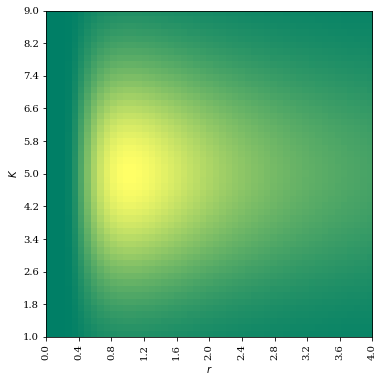

In [0]:
k_axis = []
for i in range(11):
    k_axis.append(np.round(k_grid[i*5], 2))
    
r_axis = []
for i in range(11):
    r_axis.append(np.round(r_grid[i*5],2))
    
k_axis.reverse()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(r_axis)
plt.xticks(range(len(r_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))

plt.imshow(prior_mat, cmap = cm.summer)
plt.xlabel('$r$')
plt.ylabel('$K$')
plt.show()

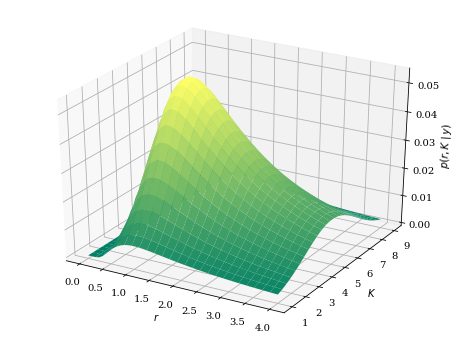

In [0]:
x, y = np.meshgrid(r_grid, k_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')


surf = ax.plot_surface(x, y, prior_mat, cmap=cm.summer,linewidth=0, antialiased=True)
ax.set_xlabel('$r$')
ax.set_ylabel('$K$')
ax.set_zlabel('$p(r, K \mid y)$')

plt.show()

In [0]:
#Calcualting the un-normalised posterior

post_mat = np.zeros((len(r_grid), len(k_grid)))

for i in range(len(r_grid)):
    for j in range(len(k_grid)):
        post_mat[len(k_grid) - j - 1, i] = posterior(r_grid[i], k_grid[j], sim_df, t, initial_N)

In [0]:
post_mat = np.nan_to_num(post_mat)
post_mat.sum()

0.00017493887674956149

In [0]:
#Normalising the posterior by approximating the evidence term of Bayes Rule

post_mat = post_mat / (post_mat.sum() * (r_grid[1] - r_grid[0]) * (k_grid[1] - k_grid[0]))

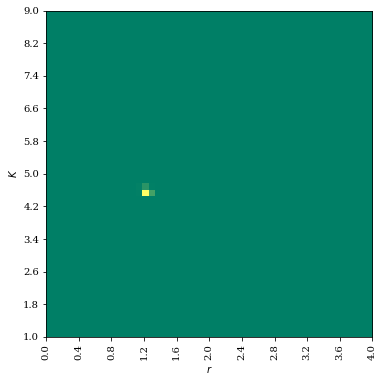

In [0]:
k_axis = []
for i in range(11):
    k_axis.append(np.round(k_grid[i*5], 2))
    
r_axis = []
for i in range(11):
    r_axis.append(np.round(r_grid[i*5],2))
    
k_axis.reverse()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(r_axis)
plt.xticks(range(len(r_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))

plt.imshow(post_mat, cmap = cm.summer)
plt.xlabel('$r$')
plt.ylabel('$K$')
plt.show()

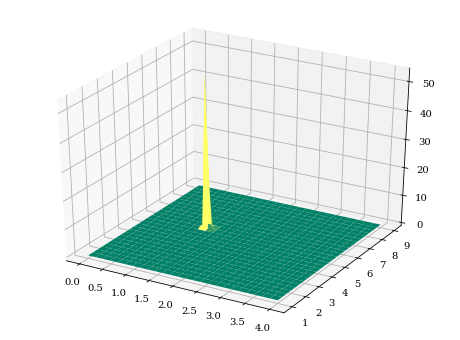

In [0]:
x, y = np.meshgrid(r_grid, k_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, post_mat, cmap=cm.summer,linewidth=0, antialiased=True)

In [0]:
#Refining our grid so that we can observe the peak more clearly

r_grid = np.linspace(1,2, 51)
k_grid = np.linspace(4, 6, 51)


#Rerun our Algorithm as before


post_mat = np.zeros((len(r_grid), len(k_grid)))

for i in range(len(r_grid)):
    for j in range(len(k_grid)):
        post_mat[len(k_grid) - j - 1, i] = posterior(r_grid[i], k_grid[j], sim_df, t, initial_N)


In [0]:
post_mat = np.nan_to_num(post_mat)

#Normalising the posterior by approximating the evidence term of Bayes Rule

post_mat = post_mat / (post_mat.sum() * (r_grid[1] - r_grid[0]) * (k_grid[1] - k_grid[0]))

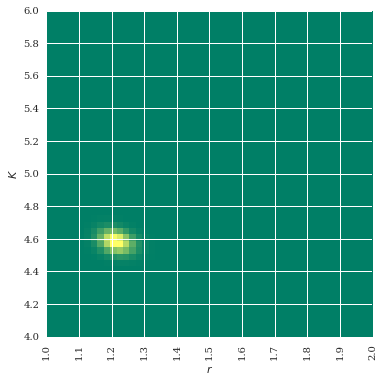

In [0]:
k_axis = []
for i in range(11):
    k_axis.append(np.round(k_grid[i*5], 2))
    
r_axis = []
for i in range(11):
    r_axis.append(np.round(r_grid[i*5],2))

k_axis.reverse()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(r_axis)
plt.xticks(range(len(r_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))


plt.imshow(post_mat, cmap = cm.summer)
plt.xlabel('$r$')
plt.ylabel('$K$')
plt.show()

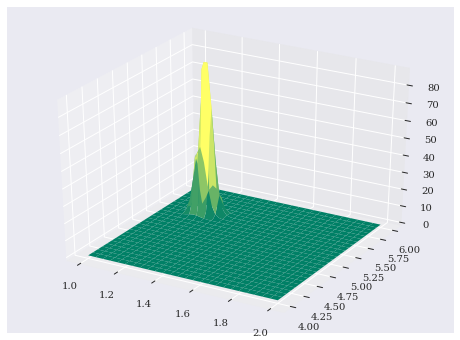

In [0]:
x, y = np.meshgrid(r_grid, k_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, post_mat, cmap=cm.summer,linewidth=0, antialiased=True)

In [0]:
#Refining once more


r_grid = np.linspace(0.9,1.5, 101)
k_grid = np.linspace(4.3, 4.9, 101)


#Rerun our Algorithm as before

start = time.time()
post_mat = np.zeros((len(r_grid), len(k_grid)))

for i in range(len(r_grid)):
    for j in range(len(k_grid)):
        start_1 = time.time()
        post_mat[len(r_grid) - j - 1, i] = posterior(r_grid[i], k_grid[j], sim_df, t, initial_N)
        end_1 = time.time()

post_mat = np.nan_to_num(post_mat)

#Normalising the posterior by approximating the evidence term of Bayes Rule

post_mat = post_mat / (post_mat.sum() * (r_grid[1] - r_grid[0]) * (k_grid[1] - k_grid[0]))

end = time.time()

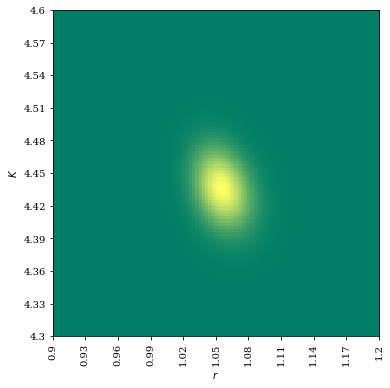

In [0]:

k_axis = []
for i in range(11):
    k_axis.append(np.round(k_grid[i*5], 2))
    
r_axis = []
for i in range(11):
    r_axis.append(np.round(r_grid[i*5],2))
    
k_axis.reverse()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(r_axis)
plt.xticks(range(len(r_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))


plt.imshow(post_mat, cmap = cm.summer)
plt.xlabel('$r$')
plt.ylabel('$K$')
plt.show()

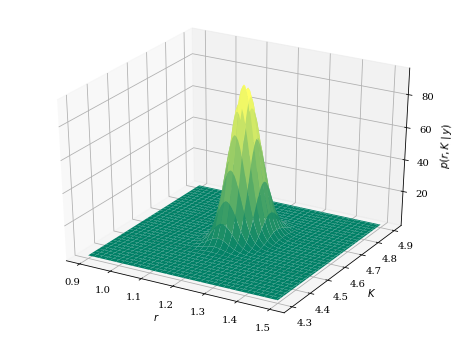

In [0]:
x, y = np.meshgrid(r_grid, k_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, post_mat, cmap=cm.summer,linewidth=0, antialiased=True)
ax.set_xlabel('$r$')
ax.set_ylabel('$K$')
ax.set_zlabel('$p(r, K \mid y)$')
plt.show()

In [0]:
 post_mat.max()

93.84935851776078

In [0]:
# Change our posterior grid matrix into a dataframe so that it is easier to find the maximal value

post_df = pd.DataFrame(post_mat)
post_df.set_index(k_grid, inplace = True)
post_df.columns = np.round(r_grid,4)
post_df.head()

,0.9,0.906,0.912,0.918,0.924,0.93,0.936,0.942,0.948,0.954,...,1.446,1.452,1.458,1.464,1.47,1.476,1.482,1.488,1.494,1.5
4.300,2.026559e-28,2.589343e-27,3.022436e-26,3.228815e-25,3.162379e-24,2.844602e-23,2.353985e-22,1.795084e-21,1.263499e-20,8.221903e-20,...,2.554957e-22,8.408254e-23,2.737718e-23,8.822124e-24,2.814471e-24,8.891906e-25,2.782914e-25,8.630610e-26,2.653060e-26,8.086141e-27
4.306,3.283266e-28,4.226836e-27,4.971041e-26,5.350365e-25,5.279475e-24,4.784336e-23,3.988545e-22,3.064036e-21,2.172554e-20,1.424108e-19,...,7.618431e-22,2.522335e-22,8.262163e-23,2.678425e-23,8.596023e-24,2.732016e-24,8.601394e-25,2.683393e-25,8.297679e-26,2.543962e-26
4.312,5.245306e-28,6.803663e-27,8.061627e-26,8.741640e-25,8.690022e-24,7.933403e-23,6.662660e-22,5.155967e-21,3.682634e-20,2.431595e-19,...,2.235302e-21,7.445293e-22,2.453436e-22,8.001204e-23,2.583222e-23,8.259023e-24,2.615705e-24,8.208651e-25,2.553318e-25,7.874312e-26
4.318,8.263285e-28,1.079868e-26,1.289087e-25,1.408220e-24,1.410274e-23,1.296983e-22,1.097242e-21,8.553281e-21,6.153720e-20,4.092757e-19,...,6.453495e-21,2.162433e-21,7.168545e-22,2.351800e-22,7.638156e-23,2.456579e-23,7.826348e-24,2.470607e-24,7.730211e-25,2.397987e-25
4.324,1.283662e-27,1.690044e-26,2.032475e-25,2.236741e-24,2.256512e-23,2.090475e-22,1.781465e-21,1.398817e-20,1.013695e-19,6.790728e-19,...,1.833333e-20,6.179949e-21,2.060925e-21,6.801644e-22,2.222173e-22,7.189337e-23,2.303984e-23,7.316094e-24,2.302584e-24,7.184766e-25


In [0]:
max_df = pd.DataFrame(index = post_df.max().index)

max_df['value'] = post_df.max().values

In [0]:
max_df['index'] = post_df.idxmax().values

In [0]:
# Finds the pair (r, K) which return the highest posterior density on our grid

max_df[ max_df['value'] == max_df['value'].max()]

,value,index
1.212,93.849359,4.63


In [0]:
# Marginalizing each parameter so that we can find the posterior Bayesian credible regions intervals

r_post = post_df.sum(0)* ((k_grid[1] - k_grid[0]))
k_post = post_df.sum(1)* ((r_grid[1] - r_grid[0]))

In [0]:
# Producing the 95% Bayesian Credible Region

r_post_df = pd.DataFrame()
r_post_df["pdf"] = r_post
r_post_df["sum"] = np.cumsum(r_post)*((r_grid[1] - r_grid[0]))

k_post_df = pd.DataFrame()
k_post_df["pdf"] = k_post
k_post_df["sum"] = np.cumsum(k_post)*((k_grid[1] - k_grid[0]))

In [0]:
r_post_df_975 = r_post_df[r_post_df["sum"] < 0.975]
r_post_df_025 = r_post_df[r_post_df["sum"] > 0.025]

r_lower_bound = r_post_df_025.index[0]
r_upper_bound = r_post_df_975.index[-1]

k_post_df_975 = k_post_df[k_post_df["sum"] < 0.975]
k_post_df_025 = k_post_df[k_post_df["sum"] > 0.025]

k_lower_bound = k_post_df_025.index[0]
k_upper_bound = k_post_df_975.index[-1]

print("-----"*7)
print("---- Credible Region for r ----")
print("         ["+ str(np.round(r_lower_bound, 3))+ ", " +str(np.round(r_upper_bound, 3)) + "]")
print("-----"*7)
print("-----"*7)
print("---- Credible Region for K ----")
print("         ["+ str(np.round(k_lower_bound, 3))+ ", " +str(np.round(k_upper_bound, 3)) + "]")
print("-----"*7)

-----------------------------------
---- Credible Region for r ----
         [1.146, 1.278]
-----------------------------------
-----------------------------------
---- Credible Region for K ----
         [4.534, 4.72]
-----------------------------------


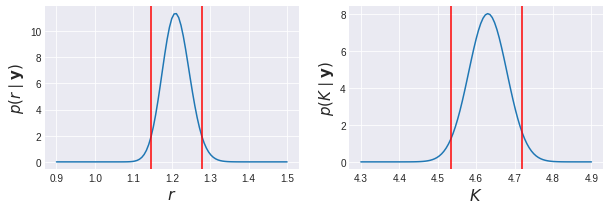

In [0]:
from matplotlib import style
style.use("seaborn-darkgrid")

f = plt.figure(figsize=(10,3))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(r_grid, r_post)
ax.set_xlabel("$r$", fontsize = 16)
ax.set_ylabel("$p(r \mid \mathbf{y})$", fontsize = 15)
ax.axvline(r_lower_bound, color = 'r')
ax.axvline(r_upper_bound, color = 'r')

ax2.plot(k_grid, k_post)
ax2.set_xlabel("$K$", fontsize = 16)
ax2.set_ylabel("$p(K \mid \mathbf{y})$", fontsize = 15)
ax2.axvline(k_lower_bound, color = 'r')
ax2.axvline(k_upper_bound, color = 'r')


plt.savefig('95_confid_grid_logistic.pdf', bbox_inches="tight")

In [0]:
#files.download('95_confid_grid_logistic.pdf')

In [0]:
#Producing an image to describe the 95% highest density regions

sol_df_low = pd.DataFrame(index = t)
sol_df_low['N'] = diff_eqn_soln(r_lower_bound, k_lower_bound, initial_N, t)

sol_df_upper = pd.DataFrame(index = t)
sol_df_upper['N'] = diff_eqn_soln(r_upper_bound, k_upper_bound, initial_N, t)

sol_df_1 = pd.DataFrame(index = t)
sol_df_1['N'] = diff_eqn_soln(r_lower_bound, k_upper_bound, initial_N, t)

sol_df_2 = pd.DataFrame(index = t)
sol_df_2['N'] = diff_eqn_soln(r_upper_bound, k_lower_bound, initial_N, t)

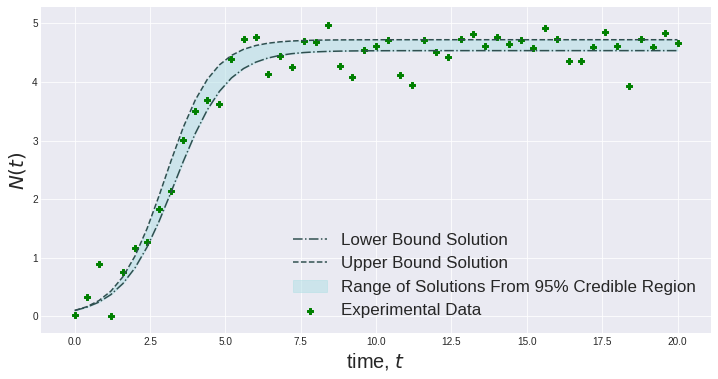

In [0]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 12
fig_size[1] = 6

ax = plt.subplot(111)
ax.plot(t, sol_df_low['N'], 'darkslategray', linestyle = '-.')
ax.plot(t, sol_df_upper['N'], 'darkslategray', linestyle = '--')
ax.fill_between(t, sol_df_low['N'], sol_df_upper['N'], alpha = 0.5, color = 'powderblue')
plt.scatter(t, sim_df['N'], color = 'g', marker = 'P')
plt.grid(True)
plt.xlabel("time, $t$", fontsize = 20)
plt.ylabel("$N(t)$", fontsize = 20)
plt.legend(["Lower Bound Solution", "Upper Bound Solution", "Range of Solutions From 95% Credible Region", "Experimental Data"], loc = 'lower right', prop = {"size": 17})
plt.savefig('grid_solution_bounds.pdf', bbox_inches = 'tight')

In [0]:
#files.download('grid_solution_bounds.pdf')